# AES Differential Side-channel Analysis

#### Coding your own selection function and distinguishers 

<img src="images/Do-It-Yourself.jpg" width="300px">

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
    
plt.rcParams["figure.figsize"] = [20, 3]

---
🅰️ Import the trace campaign you want to analyse

In [2]:
import estraces

In [3]:
ths = estraces.read_ths_from_ets_file("AES_traces_set_1st_round.ets") 

---
🅰️ Print the ths information, the ths len


In [4]:
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file AES_traces_set_1st_round.ets with 2000 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



---
🅰️ Plot the traces


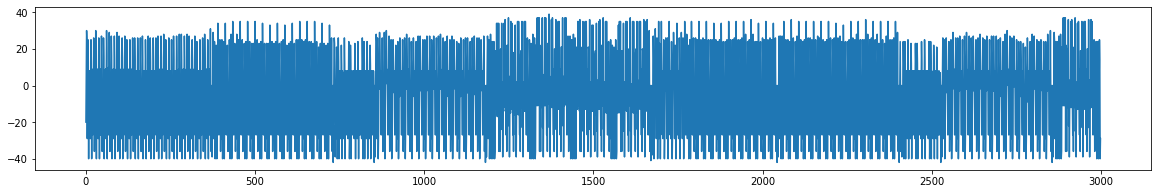

In [5]:
plt.plot(ths[0].samples.T)
plt.show()

-------------
### Doing your own selection function for scared distinguisher

---
🅰️ Code your own selection function: output of SubBytes at first round

In [8]:
from tables import SBOX

def my_select_funct_Sbox_out(data, guesses):
    key_bytes_number = 16
    S_matrix = np.zeros((len(guesses),len(data),key_bytes_number), dtype = np.uint8)
    key_guesses = [[i]*key_bytes_number for i in guesses]

    for guess in guesses:    
        for i in range(len(data)):
            plain = data[i]
            intermediate = np.bitwise_xor(plain, key_guesses[guess])
            S_matrix[guess][i] = [SBOX[intermediate[i]] for i in range(key_bytes_number)]

    return np.swapaxes(S_matrix, 0, 1)

---
🅰️ Test it

In [9]:
S_matrix = my_select_funct_Sbox_out(ths.plaintext, range(256))

In [10]:
print(S_matrix.shape)

(2000, 256, 16)


#### Use this selection function with esDynamic distinguisher

In [11]:
import scared

---
🅰️ Define it as the selection function to use in attack object

In [12]:
@scared.attack_selection_function
def sel(plaintext, guesses):
    return my_select_funct_Sbox_out(plaintext, guesses)

---
🅰️ Set the leakage modeln the distinguisher and discrimant

In [13]:
M = scared.Monobit(0)

d = scared.maxabs

---
🅰️ Set the attack

In [14]:
container = scared.Container(ths)

In [15]:
attack_dpa = scared.DPAAttack(
                selection_function=sel, 
                model=M, 
                discriminant=d)

---
🅰️ Run it

In [16]:
attack_dpa.run(container)

---
🅰️ Print and plot the result

In [17]:
from sys import path

In [18]:
path.append('/Users/bfeix/_Cyrano/Jupyter/a_helper')
#path

In [19]:
from plot_and_show_results import plot_attack_result, print_attack_result, attack_entropy

In [20]:
print_attack_result(attack_dpa, ths[0].key)

__Best guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess |0x8f|0x3|0xe7|0x7a|0xec|0x66|0x58|0xa|0x13|0x2b|0xd2|0x3b|0xf5|0x63|0x4e|0xf
score |1.56767|1.01820|1.05156|1.11015|1.60844|1.06500|1.12694|1.04306|1.64463|0.99182|0.90173|0.91205|1.34846|1.06075|1.09235|1.07254
right key |0x8f|0x3|0xe7|0x7a|0xec|0x66|0x58|0xa|0x13|0x2b|0xd2|0x3b|0xf5|0x63|0x4e|0xf
rank |1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1

### Plot the result


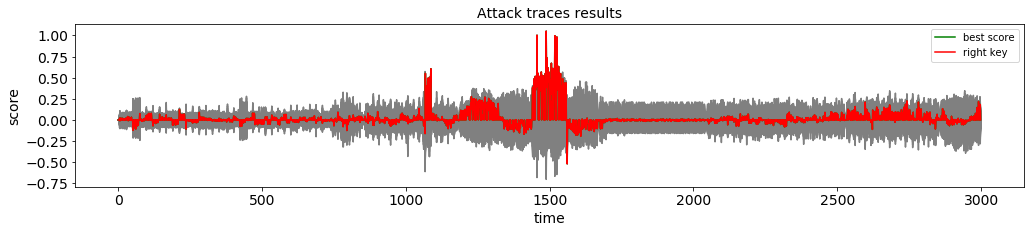

Best guess for byte 2 = 0xe7
Correct guess for byte : 2=0xe7


In [21]:
plot_attack_result(attack_dpa, 2, ths[0].key)

-------------
### Doing your own distinguisher with scared selection function

---
🅰️ Do your own Difference of Mean on traces for a given guess and selection function

In [22]:
def compute_DoM_basic_numpy(ths, selection_function_matrix, guess_value, key_byte):
    
    #create the two partitions for the DoM
    set_low = []
    set_high = []
    #sort depending on the matrix values
    progress = progress_bar.ProgressBar(len(ths))
    for trace_index in range(len(ths)):
        value = selection_function_matrix[trace_index][guess_value][key_byte]
        if (value >> 7 == 1): set_high.append(ths[trace_index:trace_index+1].get_points())
        if (value >> 7 == 0): set_low.append(ths[trace_index:trace_index+1].get_points())
            
        progress.update()
    
    DoM = np.mean(set_high, axis=0) - np.mean(set_low, axis=0) 
    #end progress bar    
    progress.finish()    
    return(DoM.T)

def compute_DoM(ths, selection_function_matrix, guess_value, key_byte):
    #create the two partitions for the DoM
    set_DoM = np.zeros((2,len(ths[0:1].get_points().T)), dtype=np.float32)
    cpt = [0,0]
    
    for trace_index in range(len(ths)):
        value = selection_function_matrix[trace_index][guess_value][key_byte]
        index = (value >> 7)
        set_DoM[index] += ths[trace_index:trace_index+1].get_points()[0]
        cpt[index] += 1
    
    DoM = (set_DoM[1]/cpt[1]) -  (set_DoM[0]/cpt[0])
    return(DoM)

#### Here we use the scared selection function

In [24]:
S = scared.aes.selection_functions.encrypt.FirstSubBytes()
#selection_function_matrix = S.compute(ths=ths)

What is the shape of the matrix given by the selection function

In [ ]:
print(selection_function_matrix.shape)

* numbers of message x number of guesses x number of key bytes
* [numbers of message][number of guesses][number of key bytes]

---
🅰️ Apply the DoM on the correct key byte value in position 0

In [ ]:
byte_key_position = 0
good_guess_byte_0 = ths[0:1].get_key()[0,byte_key_position]
print(good_guess_byte_0)

In [ ]:
DoM_traces_1 = compute_DoM(ths[0:400], selection_function_matrix, good_guess_byte_0, byte_key_position)
plt.plot(DoM_traces_1)
plt.show()

---
🅰️ Apply the DoM on an incorrect key byte value in position 0

In [ ]:
DoM_traces_1 = compute_DoM(ths[0:400], selection_function_matrix, 12, byte_key_position)
plt.plot(DoM_traces_1)
plt.show()

---
🅰️ Do your own DPA for several guesses

In [ ]:
import estoolkit2.utils.progress_bar as progress_bar

In [ ]:
def compute_DPA(ths, selection_function_matrix, key_byte, guesses_range):
    
    traces_number = len(ths)
    dpa_traces = []
 
    progress = progress_bar.ProgressBar(len(guesses_range))
    for guess_value in guesses_range:
        #create the two partitions for the DoM
        set_DoM = np.zeros((2,len(ths[0:1].get_points().T)), dtype=np.float32)
        cpt = [0,0]        
        
        for trace_index in range(len(ths)):
            value = selection_function_matrix[trace_index][guess_value][key_byte]
            index = (value >> 7)
            set_DoM[index] += ths[trace_index:trace_index+1].get_points()[0]
            cpt[index] += 1

        DoM = (set_DoM[1]/cpt[1]) -  (set_DoM[0]/cpt[0])        
        dpa_traces.append(DoM)
        
        progress.update()
        
    #end progress bar    
    progress.finish()    
    
    return(dpa_traces)

---
🅰️ Test it

In [ ]:
guesses_range = range(good_guess_byte_0-5, good_guess_byte_0+5)
DPA_result = compute_DPA(ths[0:1000], selection_function_matrix, byte_key_position, guesses_range)

---
🅰️ Plot the resulting traces

In [ ]:
for i in range(len(guesses_range)):
    plt.plot(DPA_result[i].T)
plt.title("DPA result traces")
plt.show()